# Model evaluation
- This notebook compares the performance of the two models trained to solve this exercise
- Both models have been trained with the same dataset.
- One of them is a Logistic Regression model. It was trained with the set of hyperparameters that appears in ../config/config.lr01.json, and was saved in ../models/modellr01
- The other one is a Multilayer Perceptron. It was trained with the set of hyperparameters that appears in ../config/config.mlp01.json, and was saved in ../models/modelmlp01

In [17]:
import sys
sys.path.insert(0, "../src/main/python/")
from models import ConfigManager
from models import BinaryTextClassifier

import pandas as pd
pd.set_option('display.max_colwidth', None)

## Loading the models

In [18]:
logistic_regression_model = BinaryTextClassifier(artifacts_folder='../models/modellr01')
multilayer_perceptron_model = BinaryTextClassifier(artifacts_folder='../models/modelmlp01')

## Loading the testing dataset

- Notice that this dataset is different from the dataset used to train and also different from the dataset used to validate
- The splitting of the dataset was made by the execution of the script ../it/test.01.sh

In [19]:
dataset = pd.read_csv('../data/dataset/testing_set.csv', sep=',')

## Predicting with the model
- We use here the two different models to predict over the testing texts.
- Given that and the original labels of the dataset, we can compare predictions with labels to measure the performance of the two different models
- The model returns a probability for every text, a float score between 1 and 0. To convert that to a binary label, a threshold must be defined: scores >= the threshold will be considered positive (1), the rest negatives (0)
- We calculate the optimal threshold for models by selecting the one that gets a best f1 score (a global measure for the model that combines both precision and recall)

In [21]:
texts = dataset['Tweet'].to_list()
labels = dataset['ISIS Flag'].to_list()

lr_scores = logistic_regression_model.predict(texts)
mlp_scores = multilayer_perceptron_model.predict(texts)

In [22]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def get_optimal_threshold(labels, prediction_scores):
    
    def f1_score(precision, recall):
        return (2 * precision * recall) / (precision + recall)
    
    precisions, recalls, thresholds = precision_recall_curve(
        labels, prediction_scores
    )
    
    f1_scores = []
    for index, precision in enumerate(precisions):
        f1_scores.append(
            f1_score(precision, recalls[index])
        )
    return thresholds[np.argmax(f1_scores)]

mlp_threshold = get_optimal_threshold(labels, mlp_scores)
lr_threshold = get_optimal_threshold(labels, lr_scores)

print('Optimal threshold MLP:', mlp_threshold)
print('Optimal threshold LR:', lr_threshold)

mlp_predictions = [1 if x >= mlp_threshold else 0 for x in mlp_scores]
lr_predictions = [1 if x >= lr_threshold else 0 for x in lr_scores]

Optimal threshold MLP: 0.56225085
Optimal threshold LR: 0.53683645


## Precision-Recall-F1
- As can be observed, both models get very similar performance scores
- Both models have precision over 95%, so we can be more or less confident that when the model tag a tweet as pro-ISIS it is a pro-ISIS one
- The value of recall is not so high but always over 90%. So the coverage of the model could be improved. There are several pro-ISIS tweets that the model is not able to catch
- The conclusions about the performance of the model depend on the requirements of the specific use case in which the model would be used. In a specific use case, the recall score, for example, maybe not be high enough, because finding almost all pro-ISIS tweets is critical. But in general, we can say the performance seems relatively good.
- There is not a significant difference between the performance of MLP and LR models

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

mlp_precision = precision_score(labels, mlp_predictions)
mlp_recall = recall_score(labels, mlp_predictions)
mlp_f1 = f1_score(labels, mlp_predictions)

lr_precision = precision_score(labels, lr_predictions)
lr_recall = recall_score(labels, lr_predictions)
lr_f1 = f1_score(labels, lr_predictions)

print('           ', 'MLP               ', 'LR')
print('precision: ', mlp_precision, lr_precision)
print('recall:    ', mlp_recall, lr_recall)
print('f1:        ', mlp_f1, lr_f1)


            MLP                LR
precision:  0.9639407598197038 0.9644473173884939
recall:     0.9100303951367781 0.9069908814589666
f1:         0.9362101313320826 0.9348370927318296


## Precision-Recall Curve
- As expected the precision-recall curves of the models are very similar
- And they have the typical shape of skilled model: a good score in recall doesn't mean a bad score in precision and vice versa

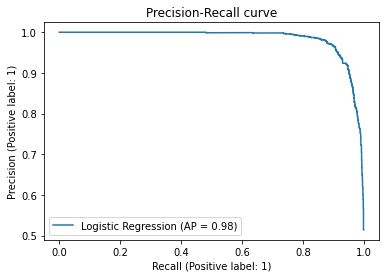

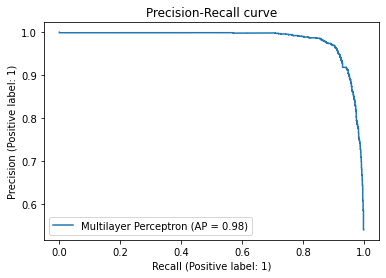

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(labels, lr_scores, name="Logistic Regression")
_ = display.ax_.set_title("Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(labels, mlp_scores, name="Multilayer Perceptron")
_ = display.ax_.set_title("Precision-Recall curve")

## Show some examples
- To have an intuitive sense of the performance of the model

In [27]:
dataset['MLP predictions'] = mlp_predictions
dataset['LR predictins'] = lr_predictions
dataset.head(200)

,ISIS Flag,Tweet,MLP predictions,LR predictins
0,0,Rudy Giuliani Offers A Head-Spinning New Defense Of Trump https://t.co/dL2gtI6ich,0,0
1,1,ISIS hackers join together in 'United Cyber Caliphate'\nhttps://t.co/2fc0iQ74iW,1,1
2,0,Gonna be streaming fortnite today but today is different because I\u2019m not gonna die all day straight WINS,0,0
3,1,RT @inglesi: Belgian press got it wrong - the arrested man this morning was not Najim Laachraoui. https://t.co/if4xEj0sOF,1,0
4,1,RT @TRACterrorism: #AbuSayyaf Group misses hostage execution deadline; rumors deadline is extended to tomorrow\n\nhttps://t.co/YfetUBVRur htt…,1,1
...,...,...,...,...
195,0,New for #ThreatHuntThursday: How to extract the C2 from a #Meterpreter payload that has been injected into memory -\u2026 https://t.co/2kRyVBTvub,0,0
196,1,Why is Asad so determined to capture Tadmur?\nHe wants to connect deir alzour and secure it before rebels do\nThen will have raqqa besieged,1,1
197,1,RT @RamiAlLolah: Western media promoted icon; sectarian #Iraq|i Shiite militant Abu Azrael promises to raise his flag on Kabaa #Saudi https…,1,1
198,1,"@BintSaaand no, it was a slip of the finger on the keyboard:)",0,0


## Understanding errors
- For further work we need to see errors and try to understand why the models fail

In [28]:
dataset_errors = dataset[(dataset['MLP predictions'] == 0) & (dataset['ISIS Flag'] == 1)]
dataset_errors.head()

,ISIS Flag,Tweet,MLP predictions,LR predictins
62,1,@dxcorcist standard magazine (30). looks fat when hold by a kid. @green_lemonnn,0,0
91,1,https://t.co/t9t3h0XFbF THE BATTLE OF THE MAHDI #WORLD #WAR,0,1
101,1,@7_Tahona @Floks_31 @Support @CtrlSec can you in tag me? Several members of my family killed by ISIS ! Please do your job properly!,0,1
139,1,Picture of the day https://t.co/w0j8SPFvZn,0,0
198,1,"@BintSaaand no, it was a slip of the finger on the keyboard:)",0,0


In [29]:
dataset_errors = dataset[(dataset['MLP predictions'] == 1) & (dataset['ISIS Flag'] == 0)]
dataset_errors.head()

,ISIS Flag,Tweet,MLP predictions,LR predictins
19,0,Advanced Scanners is born! https://t.co/bFWSayCdUy,1,1
72,0,Among the findings in the Senate Intelligence Committee Preliminary report we released this week is that during the 2016 el\u2026,1,1
163,0,"Is it safe to remove #pest using pest spray?\nSpray maybe can get rid your pest, but the spray's chemical can spread\u2026 https://t.co/9YoWILNXfT",1,0
281,0,@1nekorektna @business Not sure why you felt the need to insult beasts... lol,1,1
286,0,Its an insult to Yuvraj Singh when Axar Patel is promoted ahead of him for batting.\n#MIvKXIP,1,1


## Performance over against-ISIS texts


In [30]:
original_dataset = pd.read_csv('../data/Tweets.csv', sep=',')
negative_dataset = original_dataset[original_dataset['ISIS Flag'] == 0]
negative_dataset_with_isis = negative_dataset[negative_dataset['Tweet'].str.contains('ISIS')]
negative_texts_with_isis = negative_dataset_with_isis['Tweet'].tolist()
scores = multilayer_perceptron_model.predict(negative_texts_with_isis)
negative_dataset_with_isis['Predictions'] = [1 if x >= mlp_threshold else 0 for x in scores]
print('#negative tweets with word ISIS:', len(negative_dataset_with_isis))
negative_dataset_with_isis.head(100)

#negative tweets with word ISIS: 39


/home/benjamin/miniconda3/envs/nlp_exercise/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ISIS Flag,Tweet,Predictions
671,0,"#Americans that take the side of #MS13, ISIS, Iran, Hamas, Hezbollah, anti-Constitution advocates, #ANTIFA, open bo\u2026 https://t.co/2PdlnuKuIc",1
6125,0,@_littletoaster @PV_SIRK You know damn well your sorority was the white ISIS,1
8328,0,"@AnnCoulter @DRUDGE If any one really believes US is \fighting ISIS\"" in #Syria then let me sell you DUMB FKS a bridge to\u2026""",1
8808,0,@ashokepandit @sanjayuvacha @narendramodi @TimesNow #RahulPakAnalogy\n\nCONGRESS Joined Hands With ISIS-Recruiting Terro\u2026,0
10272,0,@BonnieFuller @realDonaldTrump MS-13 are animals. Al Qaeda are animals. ISIS are animals. Hezbollah are animals. Ha\u2026 https://t.co/hyJBHHKWgE,1
13011,0,"@DanielleLarivee @albertaNDP @RachelNotley Any comments on the PM calling Canadians Racists, comparing ISIS returnees to\u2026",0
13356,0,@deaf_robot @MSNBC Oh it will. The people like a great economy. The people like not seeing ISIS burning people aliv\u2026 https://t.co/suE1qJ3M0W,0
19106,0,@JamesMartinSJ @pittoresq Sorry. F.e. ISIS members show a behaviour that lacks all humanity. For me they are animal\u2026 https://t.co/jaIlqS0uHm,0
21234,0,"@KenRoth According to this logic, unless ISIS troops or Bin Laden present imminent threat, they cannot be killed. @KenRoth\u2026",1
22192,0,"@Ladylotteboom @ShehabiFares @Pirol11 @theresa_may Ha!?\nok..\nAre the majority of ISIS weapons Israeli, you know?",1
